In [1]:
import os, sys
import attr
# add to path
sys.path.append("../..")

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from PIL import Image
seaborn.set()

In [2]:

from filterflow.smc import SMC
from filterflow.base import State, Observation, InputsBase, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal.base import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard.systematic import SystematicResampler
from filterflow.resampling.standard.multinomial import MultinomialResampler

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

In [3]:
observation_dim = 2
state_dim = 2
T = 150
initial_state          = np.repeat(0., state_dim)
transition_matrix      = np.eye(state_dim) * 0.5
transition_covariance  = np.eye(state_dim) * 0.5

observation_matrix     = np.eye(observation_dim) *0.5
observation_covariance = np.eye(observation_dim)*0.1

In [4]:
tf_observation_matrix = tf.constant(observation_matrix, dtype = tf.float32)
tf_observation_covariance = tf.constant(observation_covariance, dtype = tf.float32)


tf_transition_matrix = tf.constant(transition_matrix, dtype = tf.float32)
tf_transition_covariance =  tf.constant(transition_covariance, dtype = tf.float32)

In [5]:
# Transition
state_dim = tf_transition_covariance.shape.as_list()[0]
transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                                    tf_transition_covariance)

transition_model = RandomWalkModel(tf_transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                             tf_observation_covariance)
observation_model = LinearObservationSampler(tf_observation_matrix, observation_error)

In [6]:
## State space model
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
initial_particle = tf.constant(np.random.random(state_dim), dtype = tf.float32)
states, observations = ss_model(initial_particle, T, return_numpy = False)

In [7]:
np_states, np_obs = ss_model.numpy(states, observations)

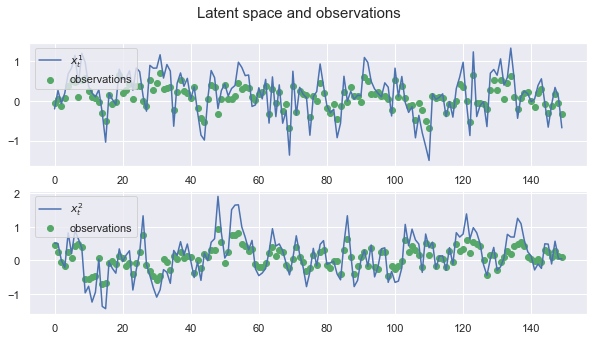

In [8]:
linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [9]:
# store observations
batch_size = 1
n_particles = 1000
dimension = 2

resampling_criterion = NeverResample()
resampling_method = NoResampling()

weights = tf.ones((batch_size, n_particles), dtype=float)/tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros((batch_size), dtype=float)
initial_state = State(particles=initial_particles, log_weights= tf.math.log(weights), weights=weights, log_likelihoods=log_likelihoods)



In [10]:
init_g_matrix = np.eye(2)
init_g_cov = np.eye(2)

init_f_matrix = np.eye(2)
init_f_cov = np.eye(2)

g_matrix = tf.Variable(init_g_matrix, dtype = tf.float32, trainable = True)
g_covariance = tf.Variable(init_g_cov, dtype = tf.float32, trainable = True)


f_matrix = tf.Variable(init_f_matrix, dtype = tf.float32, trainable = True)
f_covariance =  tf.Variable(init_f_cov, dtype = tf.float32, trainable = True)

In [11]:
var_list= [f_matrix, f_covariance, g_matrix, g_covariance]

In [12]:
# Create an optimizer.
opt = tf.keras.optimizers.Adam(learning_rate=0.05)

In [13]:
for it in range(50):
    states, observations = ss_model(initial_particle, T, return_numpy = False)
    observations_list = [observations.read(t) for t in range(T)]
    # Compute the gradients for a list of variables.
    with tf.GradientTape() as tape:
        tape.watch(var_list)
        obs = observations_list[:5]

        transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., 2), dtype=tf.float32), 
                                                                        f_covariance)
        transition_model = RandomWalkModel(f_matrix, transition_noise)

        # Observation
        observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., 2), dtype=tf.float32), 
                                                                 g_covariance)
        observation_model = LinearObservationSampler(g_matrix, observation_error)

        # proposal
        proposal_model = BootstrapProposalModel(transition_model)

        # particle filter
        particle_filter = SMC(observation_model, transition_model, 
                                                  proposal_model, resampling_criterion, resampling_method)

        final_state = particle_filter(initial_state, obs, return_final = True)

        L = -final_state.log_likelihoods / len(obs)
        grads = tape.gradient(L, var_list)
    
    # apply gradients    
    opt.apply_gradients(zip(grads,var_list))
    
    print("Iteration: {0}".format(it))
    print(var_list)
    print(L)
    print("\n")

Iteration: 0
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.95000076,  0.04999575],
       [-0.04998786,  0.95000094]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.9500004 , 0.        ],
       [0.04997947, 0.95000046]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.95000035, -0.0499918 ],
       [-0.04995317,  0.9500004 ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.9500003 , 0.        ],
       [0.04999507, 0.9500003 ]], dtype=float32)>]
tf.Tensor([2.7750363], shape=(1,), dtype=float32)


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_stat

Iteration: 2
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.8501192 ,  0.04798297],
       [-0.08130225,  0.85007083]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.8497815 , 0.        ],
       [0.01323435, 0.8501814 ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.8497537 , -0.12775624],
       [-0.1311407 ,  0.85011417]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.84986806, 0.        ],
       [0.02732371, 0.850514  ]], dtype=float32)>]
tf.Tensor([2.477716], shape=(1,), dtype=float32)


Iteration: 3
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.80034196,  0.04107747],
       [-0.05506261,  0.7998864 ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.79981077, 0.        ],
       [0.03217358, 0.8002312 ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) 

Iteration: 4
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.7507361 ,  0.04882176],
       [-0.02667388,  0.74975884]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.7499002 , 0.        ],
       [0.06157879, 0.7502379 ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.7497533 , -0.15888225],
       [-0.20361051,  0.74997187]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.74921036,  0.        ],
       [-0.04850556,  0.75010854]], dtype=float32)>]
tf.Tensor([2.0893688], shape=(1,), dtype=float32)


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_

Iteration: 6
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.65191716, 0.04152409],
       [0.0310077 , 0.6512611 ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.6501428 , 0.        ],
       [0.13829783, 0.6513622 ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.6498041 , -0.18908629],
       [-0.26215678,  0.65153694]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.6479979 ,  0.        ],
       [-0.1278786 ,  0.64961016]], dtype=float32)>]
tf.Tensor([1.7006737], shape=(1,), dtype=float32)


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_stat

Iteration: 8
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.5548473 , 0.05439329],
       [0.06456809, 0.5611036 ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.5509863 , 0.        ],
       [0.22719316, 0.5545145 ]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.5505348 , -0.24383506],
       [-0.29865208,  0.55630183]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.54537845,  0.        ],
       [-0.17526236,  0.5481306 ]], dtype=float32)>]
tf.Tensor([1.4797236], shape=(1,), dtype=float32)


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_stat

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
Iteration: 12
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.38398176, -0.00301637],
       [ 0.17271648,  0.44574678]], dtype=f

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
Iteration: 14
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.319023  , 0.00367394],
       [0.20578222, 0.38548467]], dtype=float

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
Iteration: 16
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.26585537, 0.01577875],
       [0.2275497 , 0.3390745 ]], dtype=float

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
Iteration: 18
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.22537571, 0.01376201],
       [0.24208939, 0.30632204]], dtype=float

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
Iteration: 20
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.18789247, -0.00615343],
       [ 0.2637374 ,  0.2967875 ]], dtype=f

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
Iteration: 22
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.1337737 , -0.068273  ],
       [ 0.32963723,  0.34694234]], dtype=f

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "<ipython-input-13-bbf7953503f3>", line 25, in <module>
    final_state = particle_filter(initial_state, obs, return_final = True)  File "../..\filterflow\state_space_model.py", line 102, in __call__
    return states, observations  File "../..\filterflow\state_space_model.py", line 88, in sample
    return states, observations  File "../..\filterflow\base.py", line 148, in write
    log_likelihoods=log_likelihoods)  File "c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want

Iteration: 49
[<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.10082408, -0.3389941 ],
       [ 0.36626938,  0.66505945]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.08283757,  0.        ],
       [ 0.46858996,  0.00898028]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.1386825 , -0.2612481 ],
       [-0.50956124,  0.23238131]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.29881155, 0.        ],
       [0.1074757 , 0.24138448]], dtype=float32)>]
tf.Tensor([0.34848762], shape=(1,), dtype=float32)




In [14]:

states = []
state = initial_state
for t, observation  in enumerate(obs):
    # TODO: Use the input data properly
    state = particle_filter.update(state, observation, tf.constant(0.))
    states.append(state)


In [15]:
# compute states
computed_states = []
for t, observation in enumerate(obs):
    state = states[t]
    log_weights = state.log_weights.numpy()
    particles = state.particles.numpy()[:,:,0]
    weights = np.exp(log_weights)
    computed_state = np.sum((weights * particles), axis=1)
    computed_states.append(computed_state)
    
computed_states = np.array(computed_states).flatten()

In [16]:
np_obs = np_obs[:5]

In [17]:
import numpy as np
import bqplot.pyplot as bplt
from bqplot import LinearScale, Axis, Lines, Bars, Figure
axes_options = {'x': {'label': 't'}, 'y': {'label': 'y'}}
fig = bplt.figure(animation_duration=0)
lines = bplt.plot(
                x=np.linspace(0, len(np_obs), len(np_obs)), 
                y=np_obs[:,0], 
                colors=['red'], 
                axes_options=axes_options)

if False:
    true_state_ln = bplt.plot(
                x=np.linspace(0, len(np_obs), len(np_obs)), 
                y=np_states[:,0], 
                colors=['blue'], 
                axes_options=axes_options)

computed_lin = bplt.plot(
                x=np.linspace(0, len(np_obs), len(np_obs)), 
                y=computed_states, 
                colors=['green'], 
                axes_options=axes_options)

scatt = bplt.scatter([], [], colors=['blue'], axes_options=axes_options)


max_y = np.max([np_obs[:,0]])
min_y = np.min([computed_states, np_obs[:,0]])

bplt.set_lim(min_y-0.5, max_y+0.5, 'y')
bplt.set_lim(0, len(np_obs), 'x')

fig

Figure(axes=[Axis(label='t', scale=LinearScale(max=5.0, min=0.0)), Axis(label='y', orientation='vertical', sca…